In [11]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.quantum_info import SparsePauliOp, random_hermitian
from qiskit_aer.primitives import Estimator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise import ReadoutError, depolarizing_error
from qiskit.circuit.library import IQP

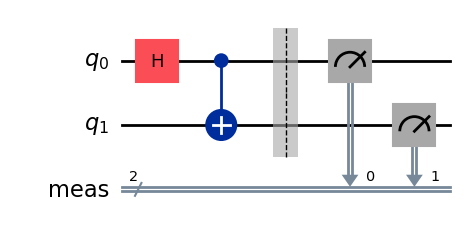

In [9]:
qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)

q0, q1 = qubits
circuit.h(q0)
circuit.cx(q0, q1)
circuit.measure_all()

circuit.draw("mpl")

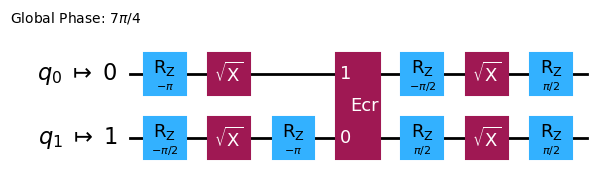

In [10]:
qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)

q0, q1 = qubits
circuit.h(q0)
circuit.cx(q0, q1)

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
pass_manager = generate_preset_pass_manager(1, backend=backend)
transpiled = pass_manager.run(circuit)

transpiled.draw("mpl", idle_wires=False)

In [11]:
qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)

q0, q1 = qubits
circuit.h(q0)
circuit.cx(q0, q1)

observable = SparsePauliOp("ZZ")
estimator = Estimator()
job = estimator.run(circuit, observable)
exact_value = job.result().values[0]
print(exact_value)

1.0


In [12]:
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

estimator = Estimator(backend_options=dict(noise_model=noise_model))

noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
bit_flip_prob = 0.05
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ['cx']
)
noise_model.add_all_qubit_readout_error(
    ReadoutError(
        [
            [1 - bit_flip_prob, bit_flip_prob],
            [bit_flip_prob, 1 - bit_flip_prob],
        ]
    )
)

In [13]:
estimator = Estimator(backend_options=dict(method='stabilizer'))

Only to run on ibm_brisbane: 

In [10]:
'''service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

n_qubits = 127
mat = np.real(random_hermitian(n_qubits, seed = 1234))
circuit = IQP(mat)
observable = SparsePauliOp('Z' * n_qubits)

estimator = Estimator()

job = estimator.run(circuit, observable)
result = job.result()'''

'service = QiskitRuntimeService()\nbackend = service.backend("ibm_brisbane")\n\nn_qubits = 127\nmat = np.real(random_hermitian(n_qubits, seed = 1234))\ncircuit = IQP(mat)\nobservable = SparsePauliOp(\'Z\' * n_qubits)\n\nestimator = Estimator()\n\njob = estimator.run(circuit, observable)\nresult = job.result()'

Creating and running simple quantum program:

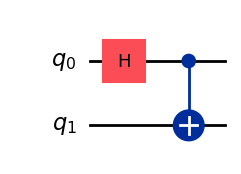

In [ ]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# 2 qubit circuit
qc = QuantumCircuit(2)

# hadamard gate to qubit 0 (sets a state 0/1)
qc.h(0)

# performs a x-gate swtich on q1 controlled by q0
qc.cx(0, 1)

# text drawing of circuit
qc.draw()
# matplotlib drawing of circuit
qc.draw('mpl')

FOR 6 OBSERVABLES:

In [23]:
# setting up 6 observables 
# gets info of Z from q1 and q1 by tensor product (correlation)
# if state is entangled output is 1

observables_labels = ['IZ', 'IX', 'ZI', 'XI', 'ZZ', 'XX']
observables = [SparsePauliOp(label) for label in observables_labels]

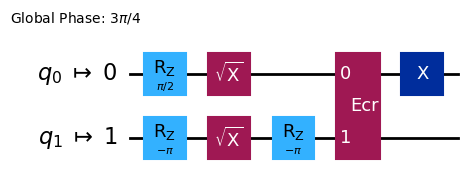

In [16]:
# optimize circuit and operators
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

# convert to ISA circuit and layout-mapped observables 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', idle_wires=False)

In [17]:
# executing quantum primitives
# quantum comps produce random results sometimes
# sample many outputs then use Estimator()

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# 1 pub and 1 circuit to run against 5 observables
job = estimator.run([(isa_circuit, mapped_observables)])

# gets job ID to get job data ltr
print(f'>>> Job ID: {job.job_id()}')

>>> Job ID: cygfhpp9b62g00821ce0


In [18]:
# this is the result of the entire submission.  only submitted 1 pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# result from single pub, which had 6 observables
# so this contains all information for all 6
pub_result = job.result()[0]

In [19]:
# FOR SIMULATOR USE NOT QC

from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

backend = FakeAlmadenV2()
estimator = Estimator(backend)
 
# convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
 
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
pub_result = job.result()[0]

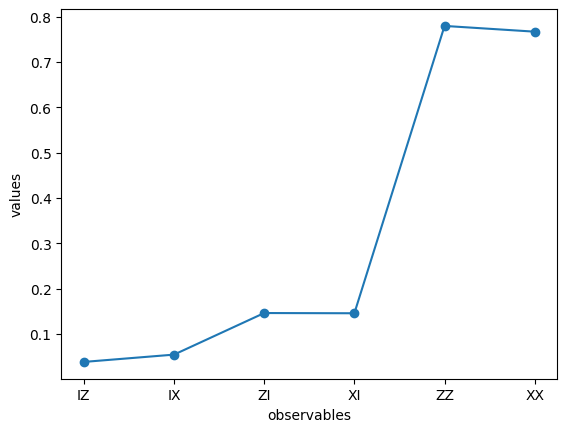

In [22]:
# analyzing results

values = pub_result.data.evs
errors = pub_result.data.stds

plt.plot(observables_labels, values, '-o')
plt.xlabel('observables')
plt.ylabel('values')
plt.show()

FOR LARGE NUMBERS OF QUBITS:

In [24]:
def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    '''creates a quantum circuit (qc) for and n-qubit GHZ state'''
    
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n - 1):
            qc.cx(i, i + 1)
    else:
        raise Exception('n is not a valid input')
    return qc

# creates a new qc for 2 qubits and 2 classical bits
n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)

In [26]:
operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (n - 2 - i) for i in range(n - 1)
]
print(operator_strings)
print(len(operator_strings))

# increasing corrupted expectation values
operators = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [27]:
# optimize for quantum hardware

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()
backend = service.least_busy(
    simulator=False, operational=True, min_num_qubits=100
)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

In [28]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = 'XY4'

# creates estimator object
estimator = Estimator(backend, options=options)

In [32]:
# submit circuit to estimator
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(f'>>> large job ID: {job_id}')

>>> large job ID: cygfzddrta1g008v4n1g


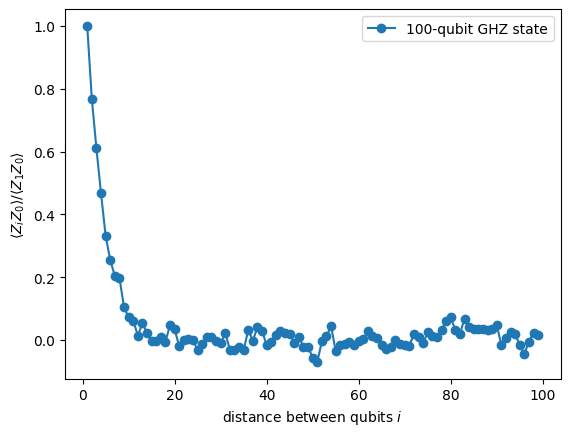

In [33]:
# data for plot
data = list(range(1, len(operators)+1)) 
result = job.result()[0]
values = result.data.evs # expectation values at each operator
values = [
    v / values[0] for v in values
]

# plotting
plt.plot(data, values, marker = 'o', label = '100-qubit GHZ state')
plt.xlabel('distance between qubits $i$')
plt.ylabel(r'$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $')
plt.legend()
plt.show()